# Bagging Activity

In [64]:
import numpy as np
import pandas as pd

mydata = pd.read_csv("/Users/jaredmcmullen/Desktop/GSB-S545/data/abalonedata.csv")
mydata

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7
...,...,...,...,...,...,...,...,...,...
4141,F,0.650,0.505,0.165,1.3570,0.5725,0.2810,0.430,11
4142,M,0.655,0.525,0.180,1.4020,0.6240,0.2935,0.365,13
4143,F,0.655,0.500,0.220,1.3590,0.6420,0.3255,0.405,13
4144,M,0.670,0.535,0.190,1.6690,0.7465,0.2935,0.508,11


In [65]:
# create the boolean variables
mydata =  pd.get_dummies(mydata) 
mydata

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings,Sex_F,Sex_I,Sex_M
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15,0,0,1
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7,0,0,1
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9,1,0,0
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10,0,0,1
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
4141,0.650,0.505,0.165,1.3570,0.5725,0.2810,0.430,11,1,0,0
4142,0.655,0.525,0.180,1.4020,0.6240,0.2935,0.365,13,0,0,1
4143,0.655,0.500,0.220,1.3590,0.6420,0.3255,0.405,13,1,0,0
4144,0.670,0.535,0.190,1.6690,0.7465,0.2935,0.508,11,0,0,1


In [54]:
from sklearn.model_selection import train_test_split

# Remove Rings and convert to 2D Array
y = mydata.Rings.values
del mydata['Rings']
X = mydata.values.astype(float)

In [55]:
#Select all the models you want to test
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVC

def get_models():
    models = dict()
    models['lr'] = LinearRegression()
    models['knn'] = KNeighborsRegressor()
    models['cart'] = DecisionTreeRegressor()
    models['rf'] = RandomForestRegressor()
    models['svm'] = SVC()
    return models
models = get_models()

{'lr': LinearRegression(),
 'knn': KNeighborsRegressor(),
 'cart': DecisionTreeRegressor(),
 'rf': RandomForestRegressor(),
 'svm': SVC()}

In [60]:
#create a function to iterate through different models
from sklearn.ensemble import BaggingRegressor
def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    models_bag = BaggingRegressor(base_estimator = model, n_estimators=10, random_state = 1)
    scores = cross_val_score(models_bag, X, y, scoring='r2', cv=cv, n_jobs=-1, error_score='raise')
    return scores

>lr 0.527 (0.047)
>knn 0.523 (0.040)
>cart 0.498 (0.045)
>rf 0.558 (0.035)
>svm 0.004 (0.083)


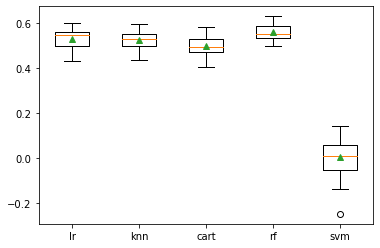

In [61]:
#Turn off warnings
import warnings
warnings.filterwarnings("ignore")

#iterate through the models and append the scores
from matplotlib import pyplot
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X, y)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

In [67]:
# Tune the hyperparameters of the bagging regressor
from sklearn.model_selection import RandomizedSearchCV

rf_model = BaggingRegressor(base_estimator = RandomForestRegressor(), random_state = 1)

n_features = 10
grid = RandomizedSearchCV(rf_model, n_iter=20, 
            param_distributions=dict(     n_estimators = (1,10), 
                                          max_features=np.arange(1, n_features+1)
                                    )
         )
grid.fit(X, y)
print(grid.best_params_)

{'n_estimators': 10, 'max_features': 10}


In [70]:
#Final model
rf_model2 = BaggingRegressor(base_estimator = RandomForestRegressor(), random_state = 1, n_estimators = 10, max_features = 10)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(rf_model2, X, y, scoring='r2', cv=cv, n_jobs=-1, error_score='raise')

mean(scores)


0.5577401599254019